# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [1]:
import numpy as np
import pandas as pd
import re
import os.path
import glob
from parse_results import process_results_xml

In [2]:
target_dir = 'C:\\Users\\s.clement\\Techbuyer Group\\Dan Burdett- Techbuyer Europe - Results - PowerEdge'


In [3]:
metrics_data = pd.DataFrame()
test_details = pd.DataFrame()
scores = pd.DataFrame()

for f in glob.glob(f'{target_dir}//**//results.xml', recursive=True):
    try:
        # Name of test directory -- sert-xxxx
        test_name = os.path.basename(os.path.dirname(f))
        
        if os.path.isfile(f'{target_dir}//{test_name}//invalid.png'):
            print(test_name, ': INVALID RESULT')
            continue
        
        metrics, score, env = process_results_xml(f)
        
        file_df = pd.DataFrame.from_records(metrics)
        # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
        calibrations = file_df.loc[file_df['loadlevel']=='calibration', ['worklet', 'score']]
        calibrations = calibrations.rename(columns={'score': 'calibration_score'})
        
        file_df = pd.merge(file_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
        file_df['actual_load'] = file_df['score'] / file_df['calibration_score']
        file_df['test-name'] = test_name
        
        score_df = pd.DataFrame.from_records(score)
        score_df['test-name'] = test_name
    
        metrics_data = metrics_data.append(file_df, ignore_index=True)
        test_details = test_details.append(pd.DataFrame.from_records(env, index=[test_name]))
        scores = scores.append(score_df, ignore_index=True)
        
    except Exception as e:
        print(f, ': FAILED -- ', e, type(e))
        

sert-0027 : INVALID RESULT
C:\Users\s.clement\Techbuyer Group\Dan Burdett- Techbuyer Europe - Results - PowerEdge\sert-0030\results.xml : FAILED --  'NoneType' object has no attribute 'text' <class 'AttributeError'>
sert-0031 : INVALID RESULT
sert-0033 : INVALID RESULT
sert-0034 : INVALID RESULT
sert-0035 : INVALID RESULT
sert-0036 : INVALID RESULT
sert-0040 : INVALID RESULT
sert-0041 : INVALID RESULT
sert-0042 : INVALID RESULT
sert-0056 : INVALID RESULT
sert-0059 : INVALID RESULT
sert-0069 : INVALID RESULT
sert-0070 : INVALID RESULT
sert-0073 : INVALID RESULT
sert-0074 : INVALID RESULT
sert-0077 : INVALID RESULT
sert-0082 : INVALID RESULT
sert-0086 : INVALID RESULT
sert-0092 : INVALID RESULT
sert-0094 : INVALID RESULT
sert-0095 : INVALID RESULT
sert-0096 : INVALID RESULT
sert-0097 : INVALID RESULT
sert-0098 : INVALID RESULT
sert-0099 : INVALID RESULT
sert-0100 : INVALID RESULT
C:\Users\s.clement\Techbuyer Group\Dan Burdett- Techbuyer Europe - Results - PowerEdge\sert-0101\results.xml 

In [4]:
metrics_data.to_csv('metrics.csv')
test_details.to_csv('test_details.csv')
scores.to_csv('scores.csv')

In [5]:
full_details = pd.DataFrame()
full_details = pd.merge(metrics_data, scores, how='left', on=['test-name', 'worklet', 'loadlevel', 'workload', 'score', 'watts-avg'])
full_details = pd.merge(full_details, test_details, left_on='test-name', right_index=True)

In [6]:
if os.path.isfile('all_data.csv'):
    overwrite = input('WARNGING - all_data.csv already exists, overwrite? (Y/N)')
    if overwrite == 'Y' or overwrite == 'y':
        full_details.to_csv('all_data.csv')
else:
    full_details.to_csv('all_data.csv')

WARNGING - all_data.csv already exists, overwrite? (Y/N)Y


In [7]:
full_details

,loadlevel,worklet,score,workload,watts-min,watts-max,watts-avg,start,end,temp-min,...,norm-score,ref-score,efficiency-score,cpu,dimm_size_mb,dimms,model,psu,ref,vendor
0,100%,Compress,3.062691e+04,CPU,443.60,459.90,453.219355,2021-07-20 17:09:13.563000+01:00,2021-07-20 17:10:14.073000+01:00,21.6875,...,4.423042,6924.40,9.759164,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.
1,75%,Compress,2.303340e+04,CPU,394.53,399.82,396.494194,2021-07-20 17:10:26.424000+01:00,2021-07-20 17:11:26.680000+01:00,21.6875,...,3.326411,6924.40,8.389558,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.
2,50%,Compress,1.536359e+04,CPU,336.89,341.17,338.587097,2021-07-20 17:11:39.005000+01:00,2021-07-20 17:12:39.239000+01:00,21.7500,...,2.218761,6924.40,6.552999,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.
3,25%,Compress,7.655040e+03,CPU,282.27,285.81,283.971935,2021-07-20 17:12:50.569000+01:00,2021-07-20 17:13:50.798000+01:00,21.6875,...,1.105517,6924.40,3.893050,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.
4,100%,CryptoAES,2.444161e+05,CPU,434.90,441.10,438.122581,2021-07-20 17:18:51.563000+01:00,2021-07-20 17:19:52.073000+01:00,21.7500,...,4.142077,59008.11,9.454151,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,Flood_Full,Flood3,6.709615e+01,Memory,236.83,246.46,241.200889,2021-08-13 07:00:45.762000+01:00,2021-08-13 07:02:36.475000+01:00,20.0625,...,5.824318,11.52,24.147166,Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz,8192,8,PowerEdge R640,750,R640-E5Silver-750W-Perf_BIOS,Dell Inc.
2987,Flood_Half,Flood3,6.790471e+01,Memory,237.96,250.52,242.167727,2021-08-13 07:02:58.368000+01:00,2021-08-13 07:03:53.551000+01:00,20.0000,...,5.894506,11.52,24.340593,Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz,8192,8,PowerEdge R640,750,R640-E5Silver-750W-Perf_BIOS,Dell Inc.
2988,Capacity3_Base,Capacity3,1.468755e+06,Memory,264.78,267.31,265.644194,2021-08-13 07:05:03.467000+01:00,2021-08-13 07:06:04.061000+01:00,20.0625,...,9.917640,148095.20,37.334300,Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz,8192,8,PowerEdge R640,750,R640-E5Silver-750W-Perf_BIOS,Dell Inc.
2989,Capacity3_Max,Capacity3,4.136407e+06,Memory,264.69,266.44,265.553871,2021-08-13 07:06:19.957000+01:00,2021-08-13 07:07:21.304000+01:00,20.0000,...,27.930731,148095.20,105.179152,Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz,8192,8,PowerEdge R640,750,R640-E5Silver-750W-Perf_BIOS,Dell Inc.


In [13]:
full_details.loc[full_details['workload'] == 'Idle', 'actual_load'] = 0

<AxesSubplot:xlabel='actual_load', ylabel='watts-avg'>

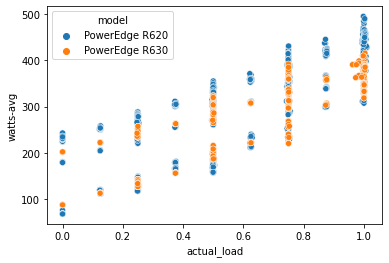

In [27]:
import seaborn as sns

cpu = full_details[(full_details['workload'] == 'CPU')| (full_details['workload'] == 'Idle')]
cpu = cpu[cpu['cpu'].str.contains('2690')]

sns.scatterplot('actual_load', 'watts-avg', hue='model', data=cpu)